In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 

### Function Definitions 

In [3]:
def cleaning_wave_df(DF):
    # dropping columns with no value
    #DF = DF.dropna(axis =1) 
    # dropping wave id column
    DF = DF.drop(columns = 2, axis =1)
    # name the first sensor columns 
    cols_0={0: "Time", 1: "FrameID", 3: "SensorID", 4: "Sensor_1Status", 5: "X_Nose", 6: "Y_Nose", 7:"Z_Nose"}
    DF = DF.rename(columns=cols_0, errors="raise")
    DF = DF.drop(columns = [8,9,10, 11], axis =1)
    
    DF = DF.drop(columns = [12,13,14,15,16,17,18,19,20], axis =1)
    cols_1={21: "SensorID", 22: "Sensor_2Status", 23: "X_LLeft", 24: "Y_LLeft", 25:"Z_LLeft"}
    DF = DF.rename(columns=cols_1, errors="raise")
    
    DF = DF.drop(columns = [26,27,28,29], axis =1)
    cols_2={30: "SensorID", 31: "Sensor_3Status", 32: "X_LR", 33: "Y_LR", 34:"Z_LR"}
    DF = DF.rename(columns=cols_2, errors="raise")
    
    DF = DF.drop(columns = [35,36,37,38], axis =1)
    cols_3={39: "SensorID", 40: "Sensor_4Status", 41: "X_UL", 42: "Y_UL", 43:"Z_UL"}
    DF = DF.rename(columns=cols_3, errors="raise")
    
    DF = DF.drop(columns = [44,45,46,47], axis =1)
    cols_4={48: "SensorID", 49: "Sensor_5Status", 50: "X_LL", 51: "Y_LL", 52:"Z_LL"}
    DF = DF.rename(columns=cols_4, errors="raise")
    
    DF = DF.drop(columns = [53,54,55,56], axis =1)
    cols_5={57: "SensorID", 58: "Sensor_6Status", 59: "X_JR", 60: "Y_JR", 61:"Z_JR"}
    DF = DF.rename(columns=cols_5, errors="raise")
    
    DF = DF.drop(columns = [62,63,64,65], axis =1)
    cols_6={66: "SensorID", 67: "Senson_7Status", 68: "X_JL", 69: "Y_JL", 70:"Z_JL"}
    DF = DF.rename(columns=cols_6, errors="raise")
    DF = DF.drop(columns = [71,72,73,74], axis =1)
    return DF

# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
    DF = DF[["BAG_Frame_number",'Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from m to mm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]*1000
    return DF

def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    Bs = B.shape
    Cs = C.shape
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area

def lipDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['Horiz_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1)
    return DF

### Reading, Cleaning, and Preprocessing DATA

In [4]:
# READ DF from WAVE
path = r'C:\Users\jafarid\Documents\Code\ValidationStudy\RM_3_20191101\WAVE\RM_3_20191101'
DF_WAVE = pd.read_csv(path +"\RM_3_20191101_004_OPEN_HOLD_1.tsv", delimiter='\t', skiprows=1,header=None)
DF_WAVE = cleaning_wave_df(DF_WAVE)
DF_WAVE = DF_WAVE.interpolate(method ='cubic', limit_direction ='forward') 
DF_WAVE = lipDist(DF_WAVE)
DF_WAVE['Vert_Lip_Motion']= gaussian_filter(DF_WAVE['Vert_Lip_Motion'], sigma=7)
DF_WAVE['Horiz_Lip_Motion']= gaussian_filter(DF_WAVE['Horiz_Lip_Motion'], sigma=7)
DF_WAVE["Speed"] = gaussian_filter(np.gradient(DF_WAVE['Vert_Lip_Motion'], DF_WAVE["Time"]), 3)

In [6]:
# READ DF from VIDEO
path = r'C:\Users\jafarid\Documents\Code\ValidationStudy\FacialTrackingProcessed'
DF_VIDEO = pd.read_csv(path+ "\\" + 'RM01_02_NSM_OPEN_HOLD_1_Landmarks3D.csv')
DF_VIDEO =  DF_VIDEO.drop([0]) 
DF_VIDEO = cleaning_video_df(DF_VIDEO)
DF_VIDEO = DF_VIDEO.interpolate(method ='cubic', limit_direction ='forward') 
DF_VIDEO = lipDist(DF_VIDEO)
DF_VIDEO['Vert_Lip_Motion']= gaussian_filter(DF_VIDEO['Vert_Lip_Motion'], sigma=7)
DF_VIDEO['Horiz_Lip_Motion']= gaussian_filter(DF_VIDEO['Horiz_Lip_Motion'], sigma=7)
DF_VIDEO["Speed"] = gaussian_filter(np.gradient(DF_VIDEO['Vert_Lip_Motion'], DF_VIDEO["Time"]), 3)

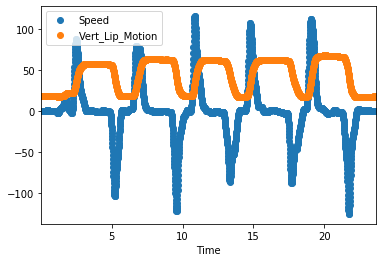

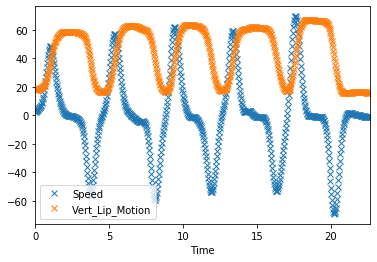

In [8]:
DF_WAVE.plot(x='Time', y=["Speed", 'Vert_Lip_Motion'], style='o')
DF_VIDEO.plot(x='Time', y=["Speed", 'Vert_Lip_Motion'], style='x')

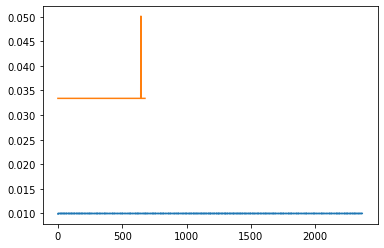

In [22]:
DF_WAVE_TIME_ARR = np.gradient(DF_WAVE['Time'])
plt.plot(DF_WAVE_TIME_ARR)
DF_VIDEO_TIME_ARR = np.gradient(DF_VIDEO['Time'])
plt.plot(DF_VIDEO_TIME_ARR)

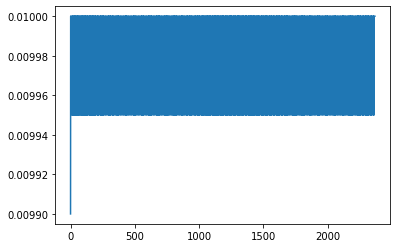

In [23]:
DF_WAVE_TIME_ARR = np.gradient(DF_WAVE['Time'])
plt.plot(DF_WAVE_TIME_ARR)

#DF_VIDEO.plot(x='Video_Frame_number', y=['Time'], style='rx')

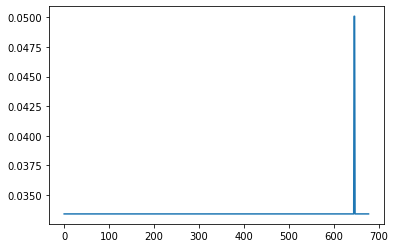

In [30]:
%matplotlib inline
DF_VIDEO_TIME_ARR = np.gradient(DF_VIDEO['Time'])
plt.plot(DF_VIDEO_TIME_ARR)

In [37]:
max(DF_VIDEO_TIME_ARR)

0.050099644999999526

In [38]:
0.0500996/0.033399

1.500032935117818

In [36]:
if DF_VIDEO.Time.diff() > 0.034: print()

1           NaN
2      0.033399
3      0.033399
4      0.033399
5      0.033399
         ...   
674    0.033400
675    0.033400
676    0.033400
677    0.033400
678    0.033400
Name: Time, Length: 678, dtype: float64

In [51]:
WAVE_30HZ = pd.DataFrame()
WAVE_30HZ['Vert_Lip_Motion'] = signal.resample_poly(DF_WAVE['Vert_Lip_Motion'], 3, 10, axis=0)
WAVE_30HZ['Time'] =signal.resample_poly(DF_WAVE['Time'], 3, 10, axis=0)
WAVE_30HZ['Speed'] =signal.resample_poly(DF_WAVE['Speed'], 3, 10, axis=0)

In [52]:
print(len(Vert_VD_30HZ))
print(len( Vert_T_30HZ))

711
711


In [54]:
WAVE_30HZ.head()

,Vert_Lip_Motion,Time,Speed
0,11.626208,0.025430,0.048143
1,19.321323,0.070001,0.075761
2,17.167338,0.099738,0.002452
3,18.336910,0.135103,-0.133801
4,17.603047,0.167164,-0.274732


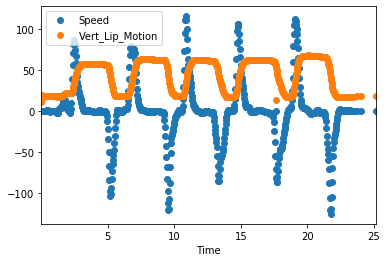

In [55]:
WAVE_30HZ.plot(x='Time', y=["Speed", 'Vert_Lip_Motion'], style='o')

In [26]:
DF_WAVE.Time.head()

0    0.0345
1    0.0444
2    0.0545
3    0.0644
4    0.0744
Name: Time, dtype: float64

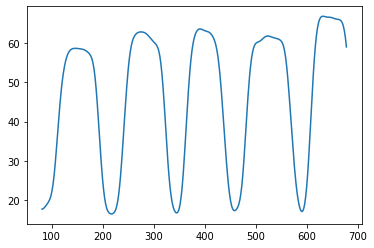

In [69]:
a = DF_VIDEO['Vert_Lip_Motion']
b = a.shift(80)
plt.plot(b)

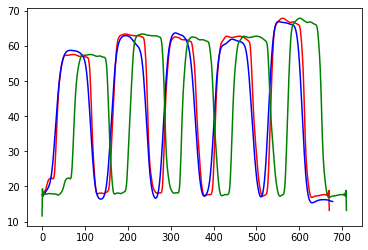

In [87]:
a = WAVE_30HZ['Vert_Lip_Motion']
b = a.shift(-40)
plt.plot(b,'r')


plt.plot(DF_VIDEO['Vert_Lip_Motion'],'b')
#plt.plot(WAVE_30HZ['Time'][80:],WAVE_30HZ['Vert_Lip_Motion'][80:])
plt.plot(WAVE_30HZ['Vert_Lip_Motion'], 'g')
#plt.plot(b)

(0, 70)

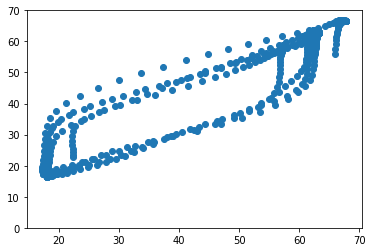

In [84]:
plt.scatter(b[20:600], DF_VIDEO['Vert_Lip_Motion'][20:600])
#plt.ylim(0,70)

In [80]:
print(b)

0      17.702247
1      17.812412
2      17.926739
3      18.046368
4      18.173481
         ...    
706          NaN
707          NaN
708          NaN
709          NaN
710          NaN
Name: Vert_Lip_Motion, Length: 711, dtype: float64


In [56]:
corr = signal.correlate(DF_VIDEO['Vert_Lip_Motion'], WAVE_30HZ['Vert_Lip_Motion'], mode='same')

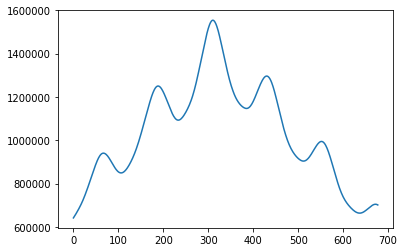

In [57]:
plt.plot(corr)

In [28]:
DF_VIDEO.Time[640:650]


641    21.375675
642    21.409075
643    21.442475
644    21.475874
645    21.509274
646    21.542674
647    21.609473
648    21.642873
649    21.676273
650    21.709673
Name: Time, dtype: float64

In [12]:
DF_VIDEO.Time[2]- DF_VIDEO.Time[1]

0.033399079999999234

In [14]:
1/0.033399

29.941016198089766